#DATASCI W261: Machine Learning at Scale

# Data Generation

1.Generate data: 2.Three clusters 3.True centroids (4,0), (6,6), (0,4)

In [8]:
 %matplotlib inline
import numpy as np
import pylab 
size1 = size2 = size3 = 10000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data, samples2, axis = 0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data, samples3, axis = 0)
# Randomlize data
data = data[np.random.permutation(size1 + size2 + size3),]
np.savetxt('Kmeandata.csv', data,delimiter = ",")


# Data Visualiazation

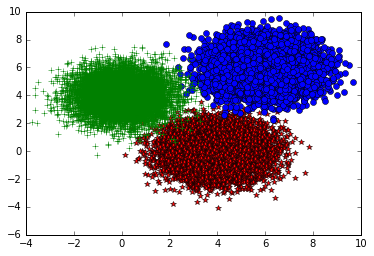

In [9]:
pylab.plot(samples1[:, 0], samples1[:, 1], '*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1], 'o', color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1], '+', color = 'green')
pylab.show()

# MrJob class for Kmeans

### If you want to change the code, please edit Kmeans.py directly

In [5]:
%%writefile Kmeans.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import chain
import os

#Calculate find the nearest centroid for data point 
def MinDist(datapoint, centroid_points):
    datapoint = array(datapoint)
    centroid_points = array(centroid_points)
    diff = datapoint - centroid_points 
    diffsq = diff * diff
    # Get the nearest centroid for each instance
    minidx = argmin(list(diffsq.sum(axis = 1)))
    return minidx

#Check whether centroids converge
def stop_criterion(centroid_points_old, centroid_points_new, T):
    oldvalue = list(chain(*centroid_points_old))
    newvalue = list(chain(*centroid_points_new))
    Diff = [
        abs(x - y) for x, 
        y in zip(oldvalue, newvalue)
    ]
    Flag = True
    for i in Diff:
        if(i > T):
            Flag = False
            break
    return Flag

class MRKmeans(MRJob):
    centroid_points=[]
    k = 3    
    def steps(self):
        return [
            MRStep(mapper_init = self.mapper_init, 
            mapper=self.mapper,
            combiner = self.combiner,
            reducer = self.reducer)
       ]
    #load centroids info from file
    def mapper_init(self):
        print "Current path:", os.path.dirname(os.path.realpath(__file__))
        
        self.centroid_points = [map(float, s.split('\n')[0].split(',')) for s in open("Centroids.txt").readlines()]
        #open('Centroids.txt', 'w').close()
        
        print "Centroids: ", self.centroid_points
        
    #load data and output the nearest centroid index and data point 
    def mapper(self, _, line):
        D = (map(float, line.split(',')))
        yield int(MinDist(D, self.centroid_points)), (D[0], D[1], 1)
    
    #Combine sum of data points locally
    def combiner(self, idx, inputdata):
        sumx = sumy = num = 0
        for x, y, n in inputdata:
            num = num + n
            sumx = sumx + x
            sumy = sumy + y
        yield idx, (sumx, sumy, num)
    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, idx, inputdata): 
        centroids = []
        num = [0] * self.k 
        for i in range(self.k):
            centroids.append([0, 0])
        for x, y, n in inputdata:
            num[idx] = num[idx] + n
            centroids[idx][0] = centroids[idx][0] + x
            centroids[idx][1] = centroids[idx][1] + y
        
        centroids[idx][0] = centroids[idx][0] / num[idx]
        centroids[idx][1] = centroids[idx][1] / num[idx]

        yield idx, (centroids[idx][0], centroids[idx][1])

if __name__ == '__main__':
    MRKmeans.run()

Overwriting Kmeans.py


# Driver:

Generate random initial centroids

New Centroids = initial centroids

While(1)：
+ Cacluate new centroids
+ stop if new centroids close to old centroids
+ Updates centroids 

In [10]:
%reload_ext autoreload
%autoreload 2
from numpy import random
from Kmeans import MRKmeans, stop_criterion
mr_job = MRKmeans(args=['Kmeandata.csv', '--file=Centroids.txt'])

#Geneate initial centroids
centroid_points = []
k = 3

for i in range(k):
    centroid_points.append([random.uniform(-3,3), random.uniform(-3,3)])
with open('Centroids.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)

# Update centroids iteratively
i = 0

while(1):
    # save previous centoids to check convergency
    centroid_points_old = centroid_points[:]
    print "iteration"+str(i)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key, value
            centroid_points[key] = value
            
        # Update the centroids for the next iteration
        with open('Centroids.txt', 'w') as f:
            f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)
        
    print "\n"
    i = i + 1
    if(stop_criterion(centroid_points_old, centroid_points, 0.01)):
        break
print "Centroids\n"
print centroid_points

iteration0:
Current path: /Users/z001gyq/Documents/GitHub/TargetDataScienceTraining_Public/Notebooks
Centroids:  [[-0.811667872416, 2.19314332016], [-0.720218515287, -2.10363368344], [-0.904327504109, 1.96446196743]]
Current path: /Users/z001gyq/Documents/GitHub/TargetDataScienceTraining_Public/Notebooks
Centroids:  [[-0.811667872416, 2.19314332016], [-0.720218515287, -2.10363368344], [-0.904327504109, 1.96446196743]]
0 [3.212859333179783, 4.375543118020398]
1 [4.013448889366686, -0.721129403971482]
2 [1.8036894529608642, 0.7038640308395223]


iteration1:
Current path: /Users/z001gyq/Documents/GitHub/TargetDataScienceTraining_Public/Notebooks
Centroids:  [[3.21285933318, 4.37554311802], [4.01344888937, -0.721129403971], [1.80368945296, 0.70386403084]]
Current path: /Users/z001gyq/Documents/GitHub/TargetDataScienceTraining_Public/Notebooks
Centroids:  [[3.21285933318, 4.37554311802], [4.01344888937, -0.721129403971], [1.80368945296, 0.70386403084]]
0 [3.639268502033081, 5.36396707639037

# Visualize the results

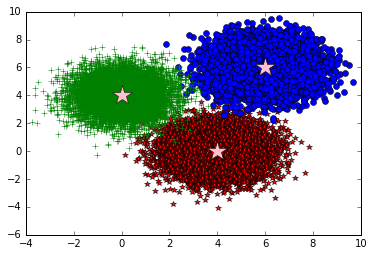

In [11]:
pylab.plot(samples1[:, 0], samples1[:, 1], '*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1], 'o', color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1], '+', color = 'green')
for point in centroid_points:
    pylab.plot(point[0], point[1], '*', color='pink', markersize=20)
pylab.show()